In [1]:
%matplotlib inline
%env CUDA_VISIBLE_DEVICE = 1

env: CUDA_VISIBLE_DEVICE=1


In [2]:
import sys

import numpy as np
import os
import blosc

import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

from tensorflow.contrib.layers import xavier_initializer_conv2d
# from scipy.interpolate import spline
from collections import defaultdict

sys.path.append("..")
    
from dataset import DatasetIndex, Dataset, F, V, B
from dataset import Batch, action, model, inbatch_parallel
from resnet import ResNet
from task_03.my_batch import MnistBatch
from task_03.my_batch import draw_stats

In [3]:
src = '..//task_03'

with open(os.path.join(src, 'mnist_pics.blk'), 'rb') as file:
    full_imgs = blosc.unpack_array(file.read())
    
with open(os.path.join(src, 'mnist_labels.blk'), 'rb') as file:
    full_labs = blosc.unpack_array(file.read())
    
src = (np.reshape(full_imgs, (65000, 28, 28)), full_labs)

In [4]:
LEN_MNIST = 65000
indy = DatasetIndex(np.arange(LEN_MNIST))

mnistset = Dataset(indy, batch_class=MnistBatch)
mnistset.cv_split([0.9, 0.1])

bch = MnistBatch(indy.create_subset(indy.indices[1:5]))

In [5]:
IMAGE_SIZE = 28
BATCH_SIZE = 100
NUM_ITERS = 200

In [6]:
placeholders_config = {
                       'images': {'shape': (IMAGE_SIZE, IMAGE_SIZE, 1),
                                 'type': 'float32',
                                 'data_format': 'channels_last',
                                 'name': 'reshaped_images'},
                
                       'labels': {'shape': 10,
                                 'type': 'float32',
                                 'name': 'targets'}
                       }

In [7]:
config={'inputs': placeholders_config,
        'input_block_config': {'layout': 'cna', 'filters': 64, 'kernel_size': 7, 'strides': 2},
        'filters':  [64, 128, 256, 512],
        'length_factor': [3, 1, 0, 0],
        'strides': [2, 1, 1, 1],
        'layout': 'ca',
        'bottleneck':True,
        'loss': 'ce',
        'dropout_rate': 0.2,
        'conv_params': {'conv': {'kernel_initializer': tf.contrib.layers.variance_scaling_initializer(factor=2.0), \
                                 'bias_initializer': tf.contrib.layers.variance_scaling_initializer(factor=2.0)}}, \
        'optimizer': {'name':'Adam', 'use_locking': True}
       }

In [8]:
ppl = (mnistset.train.p
                     .load(src=src, fmt='ndarray')
                     .init_variable('acc_history', init_on_each_run=list)
                     .init_model('dynamic', ResNet, 'MyResNet', config)
                     .train_model('MyResNet', fetches='accuracy', feed_dict={'images': B('images'),
                                                                             'labels': B('labels')},
                                 save_to=V('acc_history'), mode='a'))

In [9]:
ppl_test = (mnistset.test.p
                    .load(src=src, fmt='ndarray')
                    .init_variable('test_acc_history', init_on_each_run=list)
                    .import_model('MyResNet', ppl)
                    .predict_model('MyResNet', fetches='accuracy', feed_dict={'images': B('images'),
                                                                              'labels': B('labels')},
                                   save_to=V('test_acc_history'), mode='a'))

In [10]:
for i in tqdm(range(400)):
    ppl.next_batch(BATCH_SIZE, n_epochs=None, shuffle=True)
    ppl_test.next_batch(BATCH_SIZE, n_epochs=None, shuffle=True)

  0%|                                                                                          | 0/400 [00:00<?, ?it/s]

index  0
block_number  0
block_number  1
block_number  2
index  1
block_number  0
index  2
index  3


100%|████████████████████████████████████████████████████████████████████████████████| 400/400 [00:22<00:00, 24.60it/s]


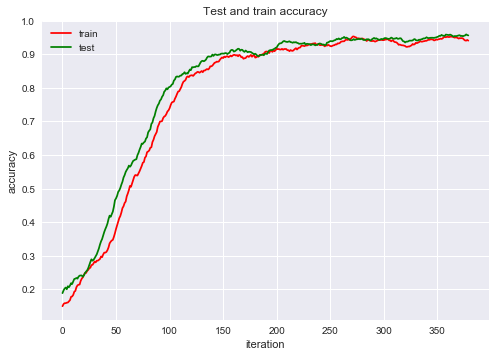

In [13]:
draw_stats([ppl.get_variable('acc_history'), ppl_test.get_variable('test_acc_history')], \
           ['train', 'test'], 'Test and train accuracy')

Average accuracy on test:

In [14]:
np.mean(np.array(ppl_test.get_variable('test_acc_history')[-100:]))

0.94899994